### 词混淆集覆盖

In [1]:
import os
import sys
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
sys.path.append('/home/chendian/BBCM/')

In [37]:
!gpustat

c10  Mon Feb 14 14:05:43 2022
[0] GeForce RTX 2080 Ti | 29'C,   0 % | 10408 / 11019 MB | cyx(10405M)
[1] GeForce RTX 2080 Ti | 29'C,   0 % |     3 / 11019 MB |
[2] GeForce RTX 2080 Ti | 29'C,   0 % |     3 / 11019 MB |
[3] GeForce RTX 2080 Ti | 29'C,   0 % |     3 / 11019 MB |
[4] GeForce RTX 2080 Ti | 30'C,   0 % |     3 / 11019 MB |
[5] GeForce RTX 2080 Ti | 28'C,   0 % |     3 / 11019 MB |
[6] GeForce RTX 2080 Ti | 27'C,   0 % |     3 / 11019 MB |
[7] GeForce RTX 2080 Ti | 62'C,  95 % | 10510 / 11019 MB | cyx(10507M)


In [1]:
dir_path = '/home/chendian/BBCM/datasets/generalization_test/'

pairs_single = {(line.split('\t')[0], line.split('\t')[1]): int(line.split('\t')[2]) for line in open(dir_path + './pairs_single_train.txt', 'r')}
pairs_multi = {(line.split('\t')[0], line.split('\t')[1]): int(line.split('\t')[2]) for line in open(dir_path + './pairs_multi_train.txt', 'r')}

In [ ]:
pairs_single = {(line.split('\t')[0], line.split('\t')[1]): int(line.split('\t')[2]) for line in open(dir_path + './pairs_single_dev.txt', 'r')}
pairs_multi = {(line.split('\t')[0], line.split('\t')[1]): int(line.split('\t')[2]) for line in open(dir_path + './pairs_multi_dev.txt', 'r')}

In [2]:
!ls ~/download/

Automatic-Corpus-Generation	   install.sh
CoNLL2003			   ltp_data_v3.4.0
README.txt			   ltp_data_v3.4.0.zip
ShannonBert			   mldmoj
ace04				   msra_ner
ace05				   ontonotes_ner
aistudio			   papers
bart-base-chinese-cluecorpussmall  python3.6_tf1.15.yaml
binaries			   resume_ner
binaries.tar.gz			   rmrb_ner
bq				   scriber_crude
bq.tar.gz			   span_bert_dqchen_base
conll03				   spanbert-base-cased
correctanswer_20211216_274.json    spanbert-large-cased
correctanswer_2021828.json	   spanbert_hf_base.tar.gz
csc_data			   stanford-corenlp-4.2.2
datafountain			   stanford-corenlp-latest.zip
fdy_csc_samples_20211221_275.json  weibo_ner
google_albert_xlarge_v2		   wget-log
google_albert_xlarge_zh


In [3]:
!ls ~/BBCM/datasets/findoc_annotations/

fdy_csc_samples_20210831.json  fdy_csc_samples_20211124.unique.json
fdy_csc_samples_20211008.json  fdy_csc_samples_20211221_275.json
fdy_csc_samples_20211009.json


In [4]:
!ls -lht /data/chendian/download/

total 16G
-rw-rw-r--  1 chendian chendian 1.9G Jan 18 16:20 texsmart-sdk-0.3.5-m-zh.tar.gz
-rw-rw-r--  1 chendian chendian 4.7G Jan  6 22:02 tencent-ailab-embedding-zh-d100-v0.2.0.tar.gz
-rw-rw-r--  1 chendian chendian 9.0G Jan  6 22:01 tencent-ailab-embedding-zh-d200-v0.2.0.tar.gz
drwxrwxr-x 15 chendian chendian 4.0K Aug  6 17:12 okcd00
drwxrwxr-x 14 chendian chendian 4.0K Jul 28 16:39 sogou_dict


### 既有字/词混淆集

In [5]:
sighan_confusion = {}
for line in open('/home/chendian/BBCM/datasets/sighan_confusion.txt', 'r'):
    k, v = line.strip().split(':')
    sighan_confusion[k] = v

In [8]:
from bbcm.utils.text_utils import is_chinese_char
vocab_chars = [line.strip() for line in open('/data/chendian/pretrained_bert_models/chinese_L-12_H-768_A-12/vocab.txt', 'r')]
vocab_chars = [c for c in vocab_chars if len(c)==1 and is_chinese_char(ord(c))]
len(vocab_chars)

7322

In [9]:
common_words = set()
for line in open('/home/chendian/BBCM/datasets/xiandai_hanyu_yongci.txt', 'r'):
    k = line.strip().split('\t')[0]
    common_words.add(k)
common_words = sorted(common_words)

In [36]:
known_token_set = load_json('../datasets/csc_py/known_token_set.json')
tencent_vocab = load_json('../datasets/csc_py/tencent_vocab.json')

> 语料中，词表覆盖情况统计

In [136]:
known_words = vocab_chars + common_words
word_count = {k: 0 for k in known_words}

In [2]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('/data/chendian/pretrained_bert_models/chinese_L-12_H-768_A-12/')
tokenizer

PreTrainedTokenizer(name_or_path='/data/chendian/pretrained_bert_models/chinese_L-12_H-768_A-12/', vocab_size=21128, model_max_len=1000000000000000019884624838656, is_fast=False, padding_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})

In [ ]:
import jieba
tokenizer.tokenize(sample['correct_text'])
list(jieba.cut(sample['correct_text']))

In [33]:
import jieba
from tqdm import tqdm
from bbcm.utils import load_json, dump_json
from collections import defaultdict
from bbcm.utils.text_utils import is_chinese_char
dir_path = "/home/chendian/BBCM/datasets/"
oov_word_count = defaultdict(int)
samples_train = load_json(dir_path + "/csc/train.json")
samples_dev = load_json(dir_path + "/csc/dev.json")
samples_test = load_json(dir_path + "/csc/test.json")

In [ ]:
from collections import OrderedDict, defaultdict
csc_origin_words = defaultdict(int)
for sample in tqdm(samples_train):
    # for word in tokenizer.tokenize(sample['correct_text']) + 
    for word in jieba.cut(sample['correct_text']):
        if False in [is_chinese_char(ord(w)) for w in word]:
            continue
        csc_origin_words[word] += 1
        # if word in word_count: word_count[word] += 1
        # else: oov_word_count[word] += 1
csc_origin_words = OrderedDict(sorted(csc_origin_words.items()))
dump_json(csc_origin_words, dir_path + "/csc/csc_words_train.json")

In [150]:
visited_words = [k for k, v in word_count.items() if v > 0]
unseen_words = [k for k, v in word_count.items() if v == 0]
len(oov_word_count), len(visited_words), len(unseen_words)

(111871, 32835, 27243)

In [157]:
len(visited_words) / (len(unseen_words) + len(visited_words))

0.5465394986517528

In [154]:
list(oov_word_count.keys())[:20]

['不能',
 '二十八日',
 '八月',
 '十二日',
 '西班牙',
 '这位',
 '目前为止',
 '此种',
 '何种',
 '一部',
 '神剧',
 '不少',
 '混合双打',
 '甘比尔',
 '以六比',
 '三比',
 '斯洛伐克',
 '艾巴提',
 '俄国',
 '投资银行']

In [155]:
unseen_words[-30:-10]

['龋齿',
 '龙井茶',
 '龙凤呈样',
 '龙吟虎啸',
 '龙套',
 '龙柏',
 '龙潭虎穴',
 '龙灯',
 '龙爪槐',
 '龙王',
 '龙王庙',
 '龙眼',
 '龙腾虎跃',
 '龙舞',
 '龙船',
 '龙虎斗',
 '龙行虎步',
 '龙袍',
 '龙钟',
 '龙门阵']

### 余弦相似度阈值分析
> (1) 根据现有标注中的 "两者均可" 类别的样本，分析句子中两者均可的词的余弦相似度分布

In [24]:
import numpy as np
def cosine_similarity(v1, v2):
    # return a value between -1 and 1
    norm = np.linalg.norm(v1) * np.linalg.norm(v2)
    if norm:
        return np.dot(v1, v2) / norm
    else:
        return 0

In [32]:
from bbcm.utils import load_json
annotation_samples = load_json('/home/chendian/download/correctanswer_20211216_274.json')
annotation_samples[2]['answer']['relations']

[{'id': 'u_0', 'type': '正确', 'operands': ['e_37']},
 {'id': 'u_1', 'type': '错误', 'operands': ['e_38']},
 {'id': 'c_0', 'operands': [], 'type': '明显错句'}]

In [45]:
from bbcm.utils import load_json
annotation_samples = load_json('/home/chendian/download/correctanswer_20211216_274.json')

from collections import defaultdict
same_pairs = defaultdict(int)

count = 0
from tqdm import tqdm
from collections import defaultdict
pairs = defaultdict(int)
for sample in tqdm(annotation_samples):
    same_flag = False
    candidates = []
    for rel in sample['answer']['relations']:
        if len(rel['operands']) == 0 and rel['type'] == '两者均可':
            same_flag = True
        else:
            candidates.append(rel['operands'])
    if not same_flag:
        continue
    
    faulty_positions = 0
    for w in sample['answer']['words']:
        if w['id'].endswith('-left'):
            faulty_positions += 1
    if faulty_positions != 1:
        continue
    ent2w = {ent['id']: ent['tokens'] for ent in sample['answer']['entities']}
    w2token = {w['id']: w['word'] for w in sample['answer']['words']}
    if len(candidates) != 2:
        continue
    r1, r2 = candidates
    e1, e2 = r1[0], r2[0]
    w1, w2 = [w2token[_e] for _e in ent2w[e1]], [w2token[_e] for _e in ent2w[e2]]
    pairs[(''.join(w1), ''.join(w2))] += 1 
    count += 1
    # break
    
count, len(pairs)

100%|███████████████████████████████████████████████████████████████████████████████| 810/810 [00:00<00:00, 73531.72it/s]


(153, 125)

In [46]:
involved_words = defaultdict(int)
for w1, w2 in sorted(pairs.keys()):
    involved_words[w1] += 1
    involved_words[w2] += 1
tok2emb = conf.load_embeddings(list(involved_words.keys()))

In [71]:
same_pair_scores = []
for w1, w2 in sorted(pairs.keys()):
    cos_sim = cosine_similarity(tok2emb[w1], tok2emb[w2])
    same_pair_scores.append(cos_sim)
    if cos_sim > 0.55 or cos_sim < 0.25:
        print(w1, w2, cos_sim)
# scores

一样 依约 0.1390233783563587
交 缴 0.6699184609574435
及 即 0.5917876304529206
型 兴 0.23601154688159584
型 性 0.5876317326695757
性 型 0.5876317326695757
持 撑 0.23630697269894027
板 棒 0.23601504743476906
档 端 0.23362953004987433
检 监 0.5891626380661642
检查 监测 0.5742486179645032
监 检 0.5891626380661642
监测 检查 0.5742486179645032
省 市 0.7311263241955986
缴 交 0.6699184609574435
虑 量 0.24262570836071612
证航空 障防控 0.5612091216173797
连接 联结 0.7485220870058271
黏 粘 0.7744097290556621


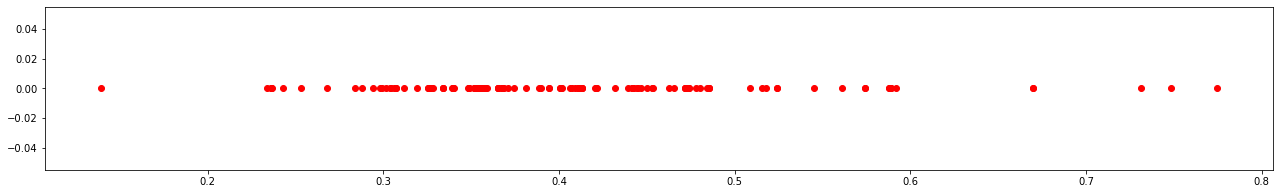

In [72]:
import numpy as np
import matplotlib.pyplot as plt
plt.figure(figsize=(22, 3))

plt.plot(same_pair_scores, [0 for _ in scores], "ro")
plt.show()

> (2) 现有标注中 "错误" 的样本，分析句子中互为错误词的余弦相似度分布

In [23]:
from tqdm import tqdm
from bbcm.utils import load_json
faulty_pairs = defaultdict(int)
fdy_samples = load_json('/home/chendian/BBCM/datasets/findoc_annotations/fdy_csc_samples_20211221_275.json')
for sample in tqdm(fdy_samples):
    last_i = -100
    os, cs = "", ""
    for cp in sample['csc_pair']:
        i, o, c = cp
        os += o
        cs += c
        if i > last_i + 1:
            if len(os) > 0:
                faulty_pairs[(os, cs)] += 1
            os, cs = "", ""
        last_i = i
len(faulty_pairs)

100%|██████████████████████████████████████████████████████████████████████████████| 729/729 [00:00<00:00, 653343.51it/s]


242

In [79]:
involved_words = defaultdict(int)
for l in faulty_pairs:
    w1, w2 = l
    involved_words[w1] += 1
    involved_words[w2] += 1
tok2emb = conf.load_embeddings(list(involved_words.keys()))

In [81]:
csc_faulty_sim_scores = []

for l in faulty_pairs:
    w1, w2 = l
    cos_sim = cosine_similarity(tok2emb[w1], tok2emb[w2])
    csc_faulty_sim_scores.append(cos_sim)
    if cos_sim > 0.6 or cos_sim < 0.2:
        print(w1, w2, cos_sim)  

， , 1.0000000000000002
帐 账 0.6957215239896489
做 作 0.6567624810969207
以 疫 0.15028954973952616
恵 惠 0.6823136582939479
的 得 0.6552914468841645
岂 起 0.183116041260281
映 应 0.14655537660651743
指 职 0.17461781053422223
营 用 0.18524193355443438
集 激 0.15517138932180669
资大 正达 0.6173061706813219
在 再 0.6233964549612402
接 阶 0.180509088412865
司公 商工 0.6081587930438438


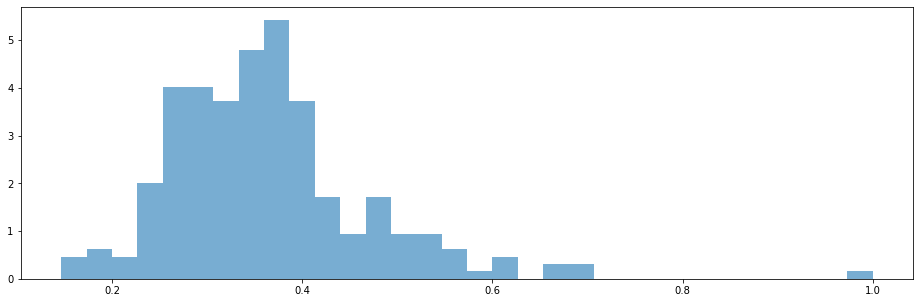

In [95]:
import numpy as np
import matplotlib.pyplot as plt
plt.figure(figsize=(16, 5))
plt.hist(csc_faulty_sim_scores, bins=32, density=True, histtype='stepfilled', alpha=0.6)
plt.show()

> (3) 根据现有(271K+SIGHAN)标注中的 "错误" 类别的样本，分析句子中互为错误的词的余弦相似度分布

In [43]:
pairs_multi_train = [line.strip() for line in open('/home/chendian/BBCM/datasets/generalization_test/pairs_multi_train.txt', 'r')]

for l in pairs_multi_train:
    w1, w2, count = l.split('\t')
    involved_words[w1] += 1
    involved_words[w2] += 1
tok2emb = conf.load_embeddings(list(involved_words.keys()))

In [44]:
faulty_sim_scores = []

for l in pairs_multi_train:
    w1, w2, count = l.split('\t')
    cos_sim = cosine_similarity(tok2emb[w1], tok2emb[w2])
    faulty_sim_scores.append(cos_sim)
    if cos_sim > 0.6 or cos_sim < 0.2:
        print(w1, w2, count, cos_sim)  


壑誉 繁荣 22 0.6455778173040921
暴咋 爆炸 17 0.6726341692824042
曰义 日益 13 0.6181800767848048
壑查 警察 13 0.6068290343002424
奇丽 绮莉 11 0.7256523508020358
在线 再现 10 0.6620511391372956
令曰 今日 10 0.6067380591553547
曰字 日子 9 0.612906164630159
皎皎 佼佼 9 0.6586341380242188
决绝 解决 8 0.8428356647548483
诩诩 栩栩 8 0.6161175722321893
即使 既是 7 0.7048673274174444
以思 意识 7 0.6003322507646168
先茌 现在 7 0.6023259772131861
实力 失利 6 0.6606194227601787
金融 锦荣 6 0.617304247450055
再次 在此 6 0.6072313852342347
是后 时候 6 0.6653495886939936
时候 事后 6 0.6579486424059221
总砀 终场 6 0.6051287651029897
迭迭 叠叠 5 0.6217698871288629
尌厉 鼓励 5 0.6229668897943715
迦南 嘉男 5 0.6419378699120051
浈淂 领导 5 0.6341081749020726
有与 由于 4 0.6214896353936337
乎掠 忽略 4 0.6590655653215388
绌绌 咄咄 4 0.6657998994722443
晓玲 小琳 4 0.7164990885190857
之一 指引 4 0.6308123398126189
汊诚 汉城 4 0.6074788817107954
是的 使得 4 0.7143557600182707
汊官 汉宫 4 0.7042011260386707
暌暌 睽睽 4 0.7172406628612521
是侯 时候 4 0.6711182089358594
骨小雨 古晓宇 4 0.6187294950849114
震震 振振 4 0.6597964655353211
影影 隐隐 4 0.61819378784

In [109]:
len(faulty_sim_scores)

8478

No handles with labels found to put in legend.


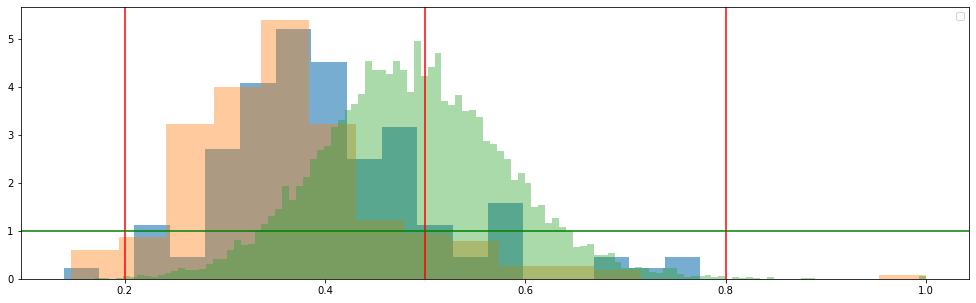

In [77]:
import numpy as np
import matplotlib.pyplot as plt
plt.figure(figsize=(17, 5))

# plt.plot(scores, [1 for _ in scores], "bo")
plt.hist(same_pair_scores, bins=18, density=True, histtype='stepfilled', alpha=0.6)  # blue
plt.axvline(0.2, color="red")
plt.axvline(0.5, color="red")
plt.axvline(0.8, color="red")
plt.hist(csc_faulty_sim_scores, bins=18, density=True, histtype='stepfilled', alpha=0.4)  # orange

plt.hist(faulty_sim_scores, bins=120, density=True, histtype='stepfilled', alpha=0.4)  # green
# plt.plot(faulty_sim_scores, [0 for _ in faulty_sim_scores], "ro")
plt.axhline(1, color="green")
plt.legend()
plt.show()

### Confusor 测试

In [1]:
# 混淆集生成组件
import os
import sys
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
sys.path.append('/home/chendian/BBCM/')
from bbcm.data.loaders.confusor import Confusor

In [2]:
conf = Confusor(
    cand_pinyin_num=10, cos_threshold=(0., 0.5), 
    method='beam', token_sample_mode='sort', pinyin_sample_mode='special', 
    weight=[1, 0.33, 1], conf_size=30, debug=False)

a = conf('短期')

Use beam method.
Pinyin sampling mode: special.
Token sampling mode: sort.
Now loading pinyin2token corpus.
Now loading zi_sim_matrix.
Now loading REDscore.
Now generating score matrix.
Load word freuency data.


In [2]:
conf = Confusor(
    cand_pinyin_num=10, cos_threshold=(0.2, 0.6), 
    method='beam', token_sample_mode='sort', pinyin_sample_mode='special', 
    weight=[1, 0.33, 1], conf_size=30, debug=False)

b = conf('短期')

Use beam method.
Pinyin sampling mode: special.
Token sampling mode: sort.
Now loading pinyin2token corpus.
Now loading zi_sim_matrix.
Now loading REDscore.
Now generating score matrix.
Load word freuency data.


In [31]:
conf = Confusor(
    cand_pinyin_num=20, cos_threshold=(0.2, 0.5), 
    method='two-stage', token_sample_mode='sort', pinyin_sample_mode='special', 
    weight=[1, 0., 1], conf_size=30, debug=False)

c = conf('短期')

Use two-stage method.
Pinyin sampling mode: special.
Token sampling mode: sort.
Now loading pinyin2token corpus.
Now loading fzimu2pinyin corpus.
Now loading REDscore.
Now loading fzimuREDscore.
Now generating score matrix.
Load word freuency data.


In [3]:
conf = Confusor(
    cand_pinyin_num=25, cos_threshold=(0.2, 0.6), 
    method='beam', token_sample_mode='sort', pinyin_sample_mode='special', 
    weight=[1, 0.33, 1], conf_size=40, debug=False)

d = conf('短期')

Use beam method.
Pinyin sampling mode: special.
Token sampling mode: sort.
Now loading pinyin2token corpus.
Now loading zi_sim_matrix.
Now loading REDscore.
Now generating score matrix.
Load word freuency data.


In [32]:
list(zip(b, c, d))

[('远期', '电气', '远期'),
 ('电气', '电器', '电气'),
 ('电器', '电企', '电器'),
 ('断期', '断期', '断期'),
 ('电企', '窗期', '电企'),
 ('端期', '创企', '端期'),
 ('短钱', '单期', '短钱'),
 ('双歧', '元气', '缓期'),
 ('算期', '段齐', '换期'),
 ('元气', '端期', '双歧'),
 ('双岐', '双歧', '算期'),
 ('算起', '算其', '元气'),
 ('单期', '算起', '关期'),
 ('段齐', '创启', '双岐'),
 ('算其', '全期', '算起'),
 ('远器', '创旗', '单期'),
 ('单戚', '双岐', '全期'),
 ('淡其', '创期', '段齐'),
 ('原期', '观其', '算其'),
 ('远启', '关期', '管期'),
 ('源期', '滇企', '劝戚'),
 ('滇企', '殿奇', '远器'),
 ('单栖', '算期', '单戚'),
 ('殿奇', '双启', '乱期'),
 ('单琪', '短钱', '官期'),
 ('袁妻', '丹气', '淡其'),
 ('双启', '旦起', '原期'),
 ('袁齐', '单戚', '远启'),
 ('元炁', '单栖', '观其'),
 ('源七', '单琪', '官岐')]

### 平均分配待增强词至句子
> see `generate_augmented_samples.ipynb`

In [43]:
from dataclasses import dataclass
from queue import PriorityQueue

@dataclass
class sample_item(object):
    idx: int
    sids: list
            
    def __lt__(self, rhs):
        return len(self.sids) < len(rhs.sids)
    
    def __gt__(self, rhs):
        return len(self.sids) > len(rhs.sids)
    
    def __le__(self, rhs):
        return len(self.sids) <= len(rhs.sids)
    
    def __ge__(self, rhs):
        return len(self.sids) >= len(rhs.sids)
    
    def __ne__(self, rhs):
        return len(self.sids) != len(rhs.sids)
    
    def __eq__(self, rhs):
        return len(self.sids) == len(rhs.sids)


In [35]:
from collections import defaultdict, Counter
Counter([2,2,3,4,4,4]).items()

dict_items([(2, 2), (3, 1), (4, 3)])

In [8]:
# pq = PriorityQueue()
# for idx, s in tqdm(enumerate(samples_train)):
#     pq.put(sample_item(idx=s['id'], sids=[]))

max_conf_count = 40
from collections import defaultdict, Counter
sentence_get_words = defaultdict(list)
words_with_no_candidates = []


def find_suitable_candidate_number(sid_case, candidates_num):
    # 1, 1, 1, 3, 5 -> 2, 2, 2, 3, 5
    # 1, 2, 4, 5, 5 -> 3, 4, 4, 5, 5
    values = [len(sentence_get_words[s]) for s in sid_case]
    counts = list(Counter(values).items())  # value, count    
    
    cur_involved_samples = 0
    for idx, (value, count) in enumerate(counts + [int(1e8)]):
        cur_involved_samples += count
        if candidates_num // count + value <= counts[idx+1][0]:
            candidates_num = cur_involved_samples
            break
    return candidate_sentences[:candidates_num]
    

for word, sids in tqdm(sorted(word_in_sentences.items(), key=lambda tup: len(tup[1]))):
    if len(word) > 4:
        continue
    candidates = conf(word)[:max_conf_count]
    candidates_num = len(candidates)  # 30 or less
    if candidates_num == 0:
        words_with_no_candidates.append(word)
        continue
    candidate_sentences = sorted([s for s in sids], 
                                 key=lambda s: len(sentence_get_words[s]))
    candidate_sentences = find_suitable_candidate_number(
        sid_case=candidate_sentences, 
        candidates_num=candidates_num)
    copies_per_candidate = candidates_num // len(candidate_sentences)
    rest_copies = candidates_num % len(candidate_sentences)
    
    allocate_pivot = 0
    last_allocate_pivot = 0
    for cs, sid in enumerate(candidate_sentences):
        allocate_pivot += copies_per_candidate
        if rest_copies:  # average on first ones.
            allocate_pivot += 1
            rest_copies -= 1
        # if cs == 0:  # the first one achieves more
        #     allocate_pivot += rest_copies
        allocate_candidates = candidates[last_allocate_pivot: allocate_pivot]
        last_allocate_pivot = allocate_pivot
        sentence_get_words[sid].extend([(word, ac) for ac in allocate_candidates])

dump_json(sentence_get_words, '/data/chendian/bbcm_datasets/csc_aug/sentence_get_words_aug40_py20.json')
# HERE

  1%|▍                                                                            | 755/146219 [02:08<4:41:28,  8.61it/s]

new pinyin: me, update zi_sim_matrix
new pinyin: me, update ziREDscore
save new zi_sim_matrix to path: /data/chendian//tencent_embedding/zi_sim_matrix.pkl
Complete ziREDscore either. Save new ziREDscore to path: /data/chendian//tencent_embedding/ziREDscore.pkl


 14%|██████████▏                                                                | 19964/146219 [54:14<3:36:59,  9.70it/s]

new pinyin: dei, update zi_sim_matrix
new pinyin: dei, update ziREDscore
save new zi_sim_matrix to path: /data/chendian//tencent_embedding/zi_sim_matrix.pkl
Complete ziREDscore either. Save new ziREDscore to path: /data/chendian//tencent_embedding/ziREDscore.pkl


 78%|█████████████████████████████████████████████████████████▋                | 113957/146219 [4:22:19<42:15, 12.73it/s]

new pinyin: den, update zi_sim_matrix
new pinyin: den, update ziREDscore
save new zi_sim_matrix to path: /data/chendian//tencent_embedding/zi_sim_matrix.pkl
Complete ziREDscore either. Save new ziREDscore to path: /data/chendian//tencent_embedding/ziREDscore.pkl


100%|██████████████████████████████████████████████████████████████████████████| 146219/146219 [5:15:31<00:00,  7.72it/s]


True

In [9]:
# dump_json(sentence_get_words, '/home/chendian/BBCM/datasets/csc_aug/sentence_get_words.json')
# sentence_get_words = load_json('/home/chendian/BBCM/datasets/csc_aug/sentence_get_words.json')

In [11]:
sentence_words_dist = list(map(len, sentence_get_words.values()))

In [12]:
sum(sentence_words_dist)

4165271

In [15]:
from collections import Counter
max(sentence_words_dist), Counter(sentence_words_dist).most_common()[:30]

(640,
 [(4, 88982),
  (5, 18362),
  (6, 11452),
  (7, 8435),
  (8, 7469),
  (10, 6954),
  (3, 6877),
  (9, 6413),
  (11, 6232),
  (12, 5115),
  (13, 4880),
  (14, 4783),
  (15, 4236),
  (20, 3880),
  (16, 3537),
  (40, 3481),
  (21, 3285),
  (17, 3152),
  (18, 2727),
  (22, 2674),
  (41, 2446),
  (19, 2419),
  (23, 2289),
  (24, 2029),
  (42, 1875),
  (25, 1770),
  (26, 1548),
  (43, 1467),
  (28, 1298),
  (27, 1290)])

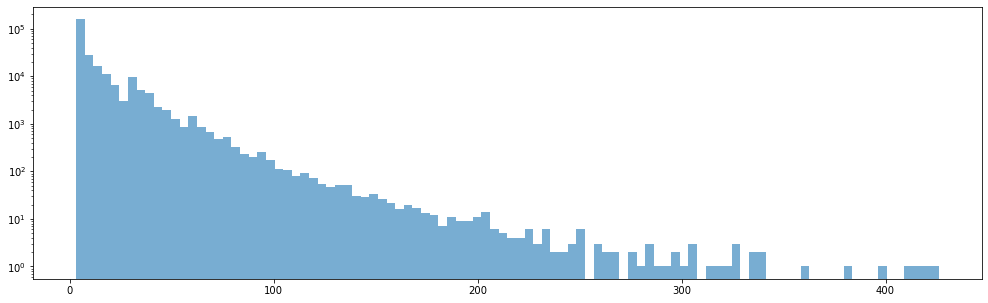

In [102]:
import numpy as np
import matplotlib.pyplot as plt
plt.figure(figsize=(17, 5))
# plt.plot(scores, [1 for _ in scores], "bo")
plt.hist(sentence_words_dist, bins=100, density=False, histtype='stepfilled', alpha=0.6)  # blue
plt.semilogy()
plt.show()

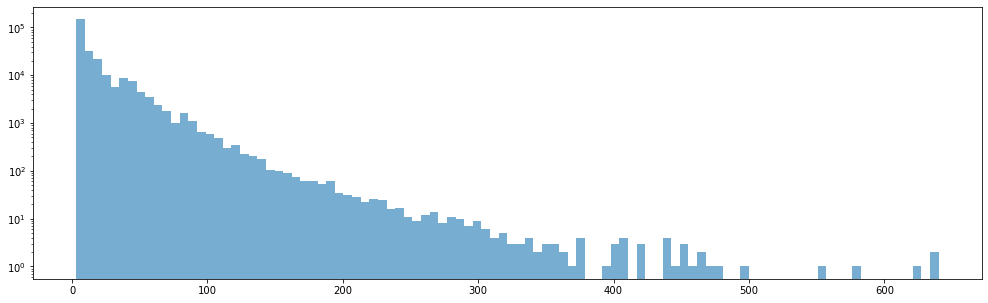

In [13]:
import numpy as np
import matplotlib.pyplot as plt
plt.figure(figsize=(17, 5))
# plt.plot(scores, [1 for _ in scores], "bo")
plt.hist(sentence_words_dist, bins=100, density=False, histtype='stepfilled', alpha=0.6)  # blue
plt.semilogy()
plt.show()

In [23]:
!ls -lht /home/chendian/BBCM/datasets/csc_aug/

total 3.5G
-rw-rw-r-- 1 chendian chendian 1.4G Feb  1 13:24 train_aug30_bbcm_1copy.with_origin.json
-rw-rw-r-- 1 chendian chendian 264M Jan 30 07:19 sentence_get_words_aug40_py20.json
-rw-rw-r-- 1 chendian chendian  507 Jan 29 01:31 conf_for_aug.220129.txt
-rw-rw-r-- 1 chendian chendian 139M Jan 28 04:42 sentence_get_words_aug20.json
-rw-rw-r-- 1 chendian chendian 1.3G Jan 27 19:56 train_aug30_bbcm_1copy.json
-rw-rw-r-- 1 chendian chendian 188M Jan 27 19:18 sentence_get_words_aug30.json
-rw-rw-r-- 1 chendian chendian  60M Jan 26 00:44 sentence_get_words.json
-rw-rw-r-- 1 chendian chendian 188M Jan 21 17:12 word_in_sentences.json


In [79]:
conf('惊天动地')

['擎天动地', '惊天恸地', '殷天动地', '冰天冻地', '冰天动地', '冻天冻地', '寒天冻地']

In [104]:
sentence_get_words[0]

[('激活', '机会'),
 ('激活', '肌活'),
 ('激活', '集货'),
 ('激活', '几乎'),
 ('激活', '激火'),
 ('激活', '机活'),
 ('健身', '渐生'),
 ('伴侣', '办了')]

In [30]:
samples_train[0]['correct_text'].index('侣')

1

In [22]:
from collections import defaultdict
from bbcm.utils.text_utils import clean_text

def generate_packed_samples(samples, sentence_get_words, confusor, pair_copies=1):
    ret_samples = []
    confusor_record = defaultdict(int)
    for idx, sample in tqdm(enumerate(samples)):
        text = clean_text(sample['correct_text'])
        # words = list(jieba.cut(text))
        words_to_change = sentence_get_words[idx]
        for word, changed_word in words_to_change:
            _target = text.index(word)
            # cur_index = confusor_record[word]
            # candidates = confusor(word)
            # if len(candidates) == 0:
            #     changed_word = word
            # else:
            #     changed_word = candidates[cur_index % len(candidates)]
            # faulty_words = [_tok if _i != _target else candidate for _i, _tok in enumerate(text)]
            faulty_text = "{}{}{}".format(text[:_target], changed_word, text[_target+len(word):])
            wrong_ids = [idx for idx, (_c, _o) in enumerate(zip(text, faulty_text)) if _c != _o]
            ret_samples.append({
                'id': "{}-{}-{}".format(sample['id'], word, confusor_record[word]),
                'correct_text': text,
                'original_text': faulty_text,
                'wrong_ids': wrong_ids,
            })
            confusor_record[word] += 1
    return ret_samples


ret_samples = generate_packed_samples(
    samples=samples_train, 
    sentence_get_words=sentence_get_words, 
    confusor=conf, pair_copies=1)
ret_samples = samples_train + ret_samples
len(ret_samples)

254004it [01:28, 2878.82it/s]


4419275

In [29]:
!ls -lht /data/chendian/bbcm_datasets/csc_aug

total 3.3G
-rw-rw-r-- 1 chendian chendian 1.4G Feb  2 14:52 train_aug30_bbcm_1copy.json
-rw-rw-r-- 1 chendian chendian 1.9G Feb  2 13:32 train_aug40_bbcm_1copy.json


In [24]:
# dump_json(ret_samples, '/home/chendian/BBCM/datasets/csc_aug/train_aug40_bbcm_1copy.json')
dump_json(ret_samples, '/data/chendian/bbcm_datasets/csc_aug/train_aug40_bbcm_1copy.json')

True

In [27]:
!cp /data/chendian/bbcm_datasets/csc_aug/train_aug40_bbcm_1copy.json  /home/chendian/BBCM/datasets/csc_aug/

In [ ]:
csc_origin_words = defaultdict(int)
for sample in tqdm(samples_train):
    # for word in tokenizer.tokenize(sample['correct_text']) + 
    for word in jieba.cut(sample['correct_text']):
        if False in [is_chinese_char(ord(w)) for w in word]:
            continue
        csc_origin_words[word] += 1
        # if word in word_count: word_count[word] += 1
        # else: oov_word_count[word] += 1